# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Calculate-the-correct-camera-matrix-and-distortion-coefficients" data-toc-modified-id="Calculate-the-correct-camera-matrix-and-distortion-coefficients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate the correct camera matrix and distortion coefficients</a></div><div class="lev2 toc-item"><a href="#Radial-Distortion" data-toc-modified-id="Radial-Distortion-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Radial Distortion</a></div><div class="lev2 toc-item"><a href="#Tangential-Distortion" data-toc-modified-id="Tangential-Distortion-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tangential Distortion</a></div><div class="lev2 toc-item"><a href="#To-undistortion" data-toc-modified-id="To-undistortion-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>To undistortion</a></div><div class="lev1 toc-item"><a href="#Calculate-the-correct-camera-matrix-and-distortion-coefficients" data-toc-modified-id="Calculate-the-correct-camera-matrix-and-distortion-coefficients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate the correct camera matrix and distortion coefficients</a></div><div class="lev2 toc-item"><a href="#Radial-Distortion" data-toc-modified-id="Radial-Distortion-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Radial Distortion</a></div><div class="lev2 toc-item"><a href="#Tangential-Distortion" data-toc-modified-id="Tangential-Distortion-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tangential Distortion</a></div><div class="lev2 toc-item"><a href="#To-undistortion" data-toc-modified-id="To-undistortion-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>To undistortion</a></div><div class="lev2 toc-item"><a href="#Visualize-Undistorted-Test-Image" data-toc-modified-id="Visualize-Undistorted-Test-Image-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize Undistorted Test Image</a></div><div class="lev2 toc-item"><a href="#Perspective-Transform" data-toc-modified-id="Perspective-Transform-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Perspective Transform</a></div><div class="lev2 toc-item"><a href="#Color-Thresholding,-Binary-Thresholding" data-toc-modified-id="Color-Thresholding,-Binary-Thresholding-26"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Color Thresholding, Binary Thresholding</a></div><div class="lev2 toc-item"><a href="#Histogram-Filtering-and-Calculate-curvature" data-toc-modified-id="Histogram-Filtering-and-Calculate-curvature-27"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Histogram Filtering and Calculate curvature</a></div><div class="lev2 toc-item"><a href="#Apply-to-movie" data-toc-modified-id="Apply-to-movie-28"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Apply to movie</a></div>

In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Calculate the correct camera matrix and distortion coefficients

## Radial Distortion
Radial Distortion means the distortion that was created from curved lenses of real cameras.  
curved lenses bend lights rays too mauch or too little at the edge of lenses.  
this create an effect that distorts the edges of images, so that lines or objects appear more or less curved than they acutually are.  
There are three coefficients needed to correct for radial distortion: k1, k2, and k3.  

## Tangential Distortion
Tangential Distortion means the distortion that was affected from the angle of camera or sensors.  
These are two coefficients needed to correct for tangential distortion: p1, p2


## To undistortion

In [2]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return objpoints, imgpoints, mtx, dist

objpoints, imgpoints, mtx, dist = get_calibration_param('./camera_cal/calibration*.jpg')
np.savez("./calibration.npz",mtx=mtx, dist=dist)

finish get_calibration_param


In [3]:
def get_undistortion(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

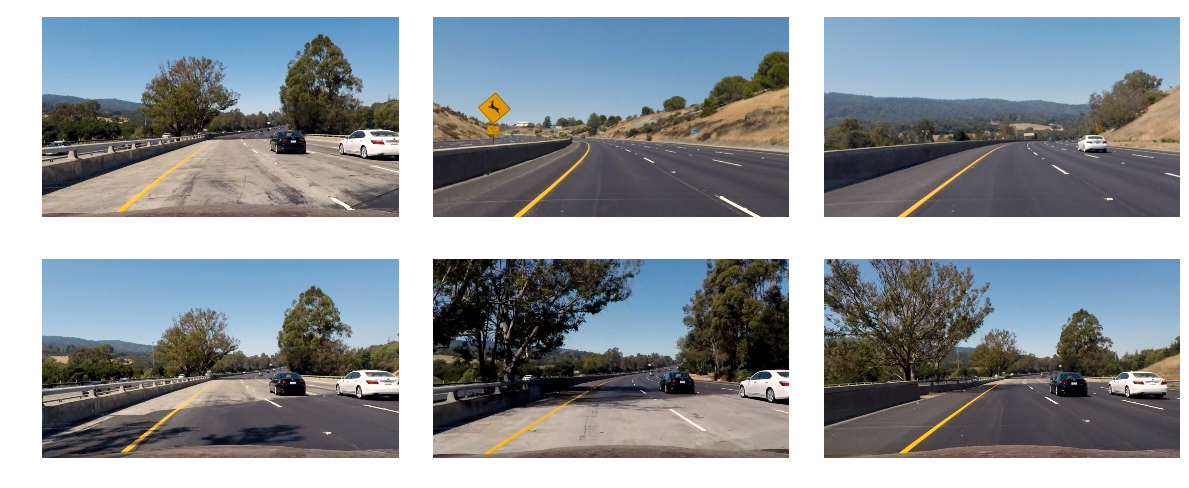

In [4]:
try:
    calibration_param = np.load('./calibration.npz')
except IOError as e:
    print("There is no file like path")
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            axes[i, j].imshow(undist_img)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

In [6]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [7]:
def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=40, ysteps=3, window_width=10)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [8]:
def process_image(image):
#     OFFSET = 105
#     SRC = np.float32([
#     (380, 720),
#     (620, 455),
#     (720, 455),
#     (1200, 720)])
#     a = 50
#     DST = np.float32([
#         (SRC[0][0] - a + OFFSET, SRC[0][1]),
#         (SRC[0][0] - a + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
#     OFFSET = 200 BEST
#     SRC = np.float32([
#         (300, 720),
#         (580, 455),
#         (730, 455),
#         (1100, 720)])
    OFFSET = 140
    SRC = np.float32([
        (300, 720),
        (595, 455),
        (700, 455),
        (1100, 720)])
    
    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './my.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

NameError: name 's' is not defined

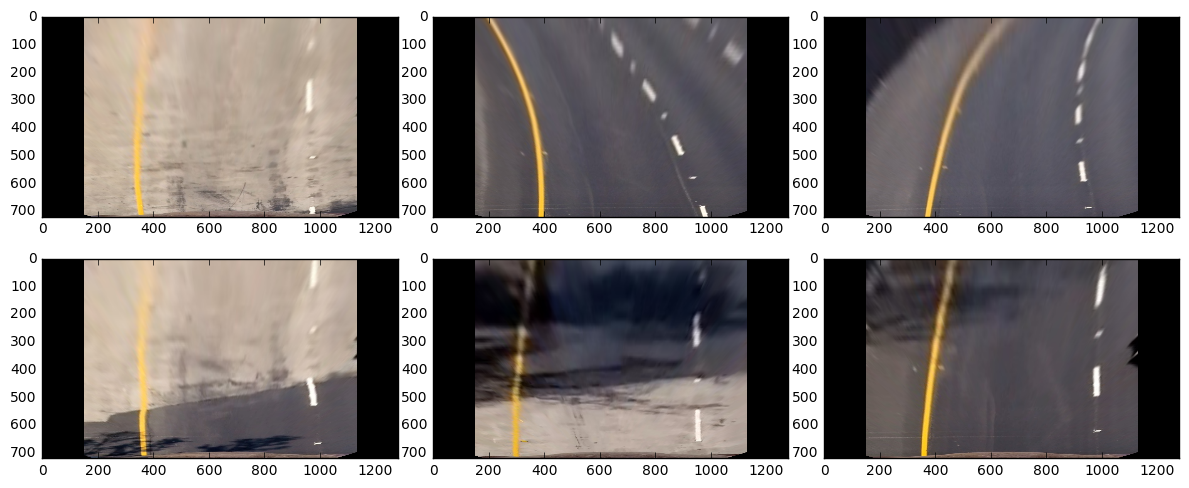

In [53]:
def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary

def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        white = get_white_line(undist_img)
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary, white

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img, white = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(undist_img)
        top_down[:, :150] = 0
        top_down[:, 1130:] = 0
        return undist_img, s_binary, slope, conversion_img, top_down

if __name__ == '__main__':
    OFFSET = 120
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
#     DST = np.float32([
#         (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
#         (SRC[0][0] - 50 + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, color, slope, conversion_img, top_down = ld.process_image(image)
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

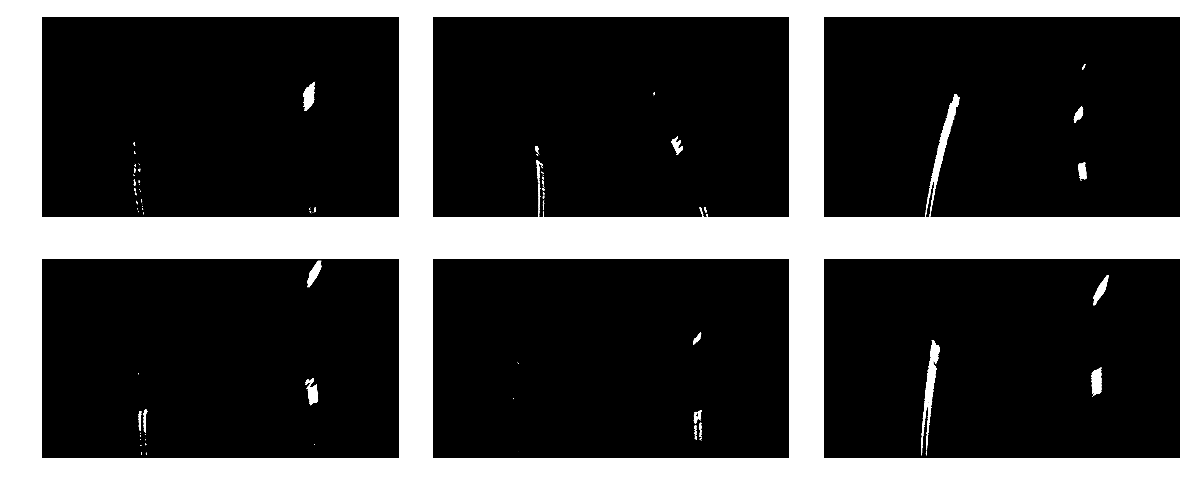

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary



def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        return top_down
#         top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=20, ysteps=5, window_width=15)
#         new_image = np.zeros_like(top_down)
#         for yv, ll in zip(yvals, left_lines):
#             new_image[yv, ll-10:ll+10] = 1
#         for yv, rl in zip(yvals, right_lines):
#             new_image[yv, rl-10 : rl+10] = 1
        
#         new_image = self.perspective_transform.inv_transform(new_image)
#         color=[255, 0, 0]
#         index = np.where(new_image == 1)
#         pt = np.vstack((index[1], index[0]))
#         pt = np.transpose(pt)

#         cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
#         undist_img[new_image==1] = color
#         return undist_img
    

if __name__ == '__main__':
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

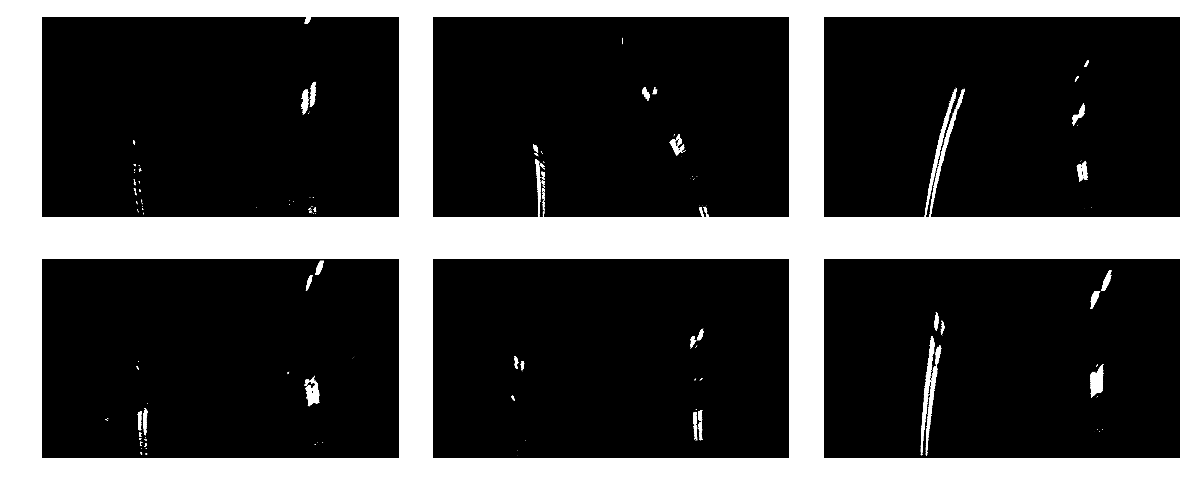

In [128]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.3)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=3)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(30, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        top_down[:, :130] = 0
        top_down[:, 1150:] = 0
        top_down[:, 600: 680] = 0
        return top_down


if __name__ == '__main__':
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

In [1]:
import sys
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Calculate the correct camera matrix and distortion coefficients

## Radial Distortion
Radial Distortion means the distortion that was created from curved lenses of real cameras.  
curved lenses bend lights rays too mauch or too little at the edge of lenses.  
this create an effect that distorts the edges of images, so that lines or objects appear more or less curved than they acutually are.  
There are three coefficients needed to correct for radial distortion: k1, k2, and k3.  

## Tangential Distortion
Tangential Distortion means the distortion that was affected from the angle of camera or sensors.  
These are two coefficients needed to correct for tangential distortion: p1, p2


## To undistortion

In [2]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return mtx, dist

def get_undistortion(distorted_img, mtx, dist):
    undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    return undist

In [3]:
def input_calibration_file(path="./calibration.npz"):
    try:
        calibratin_param = np.load(path)
        return calibration_param
    except IOError as e:
        raise IOError("Please Set Correct Calibration File")

In [4]:
class Line():
    def __init__(self):
        self.detected = False
        self.recent_xfitted = []
        self.bestx = None
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvatur of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicles center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype="float")
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        
    def process_image(self, image):
        try:
            calibration_param = input_calibration_file()
        except IOError as e:
            print(e)
            sys.exit()

In [5]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)

finish get_calibration_param


## Visualize Undistorted Test Image

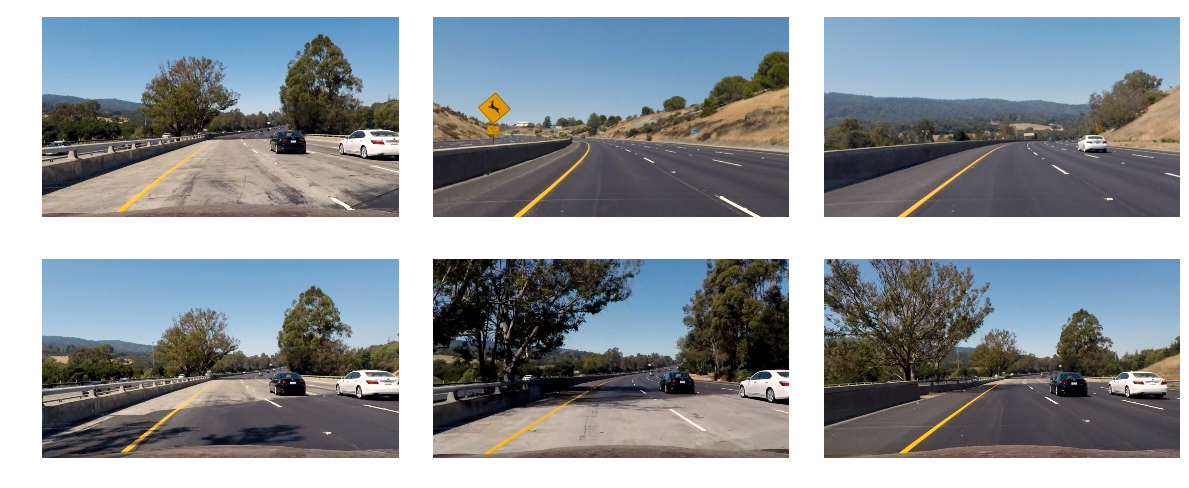

In [6]:
try:
    calibration_param = np.load('./calibration.npz')
except IOError as e:
    print("There is no file like path")
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            axes[i, j].imshow(undist_img)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Perspective Transform

In [7]:
class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

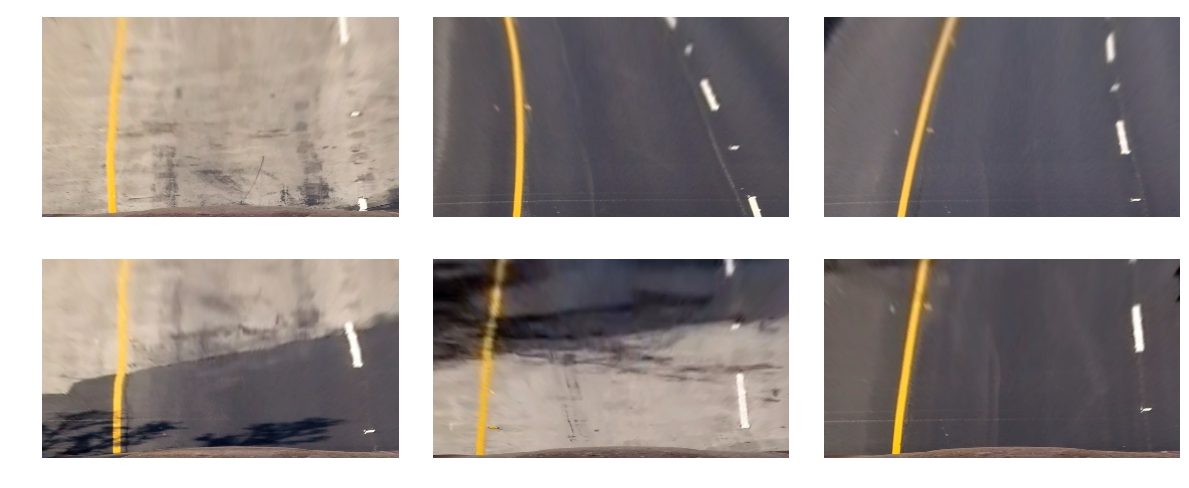

In [8]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])

    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

    bird_view_transformer = Perspective_Transform(src, dst)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            bird_view = bird_view_transformer.transform(undist_img)
            axes[i, j].imshow(bird_view)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Color Thresholding, Binary Thresholding

In [9]:
def get_s_binary(undist_img, thres=(110, 255)): #110
    #undist_img = adjust_gamma(undist_img, 0.95)
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1 #30
    s_binary = gaussian_blur(s_binary, kernel_size=21)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    #dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.3, 1.8))    
    #slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=9) # 5

    return slope_binary

def color_slope_thres_conversion(undist_img):
    s_binary = get_s_binary(undist_img, thres=(150, 255))
    slope = get_slope(undist_img, orient='x',sobel_kernel=7, thres=(25, 255)) #3, 30

    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (slope == 1)] = 1
    
    return s_binary, slope, color_binary

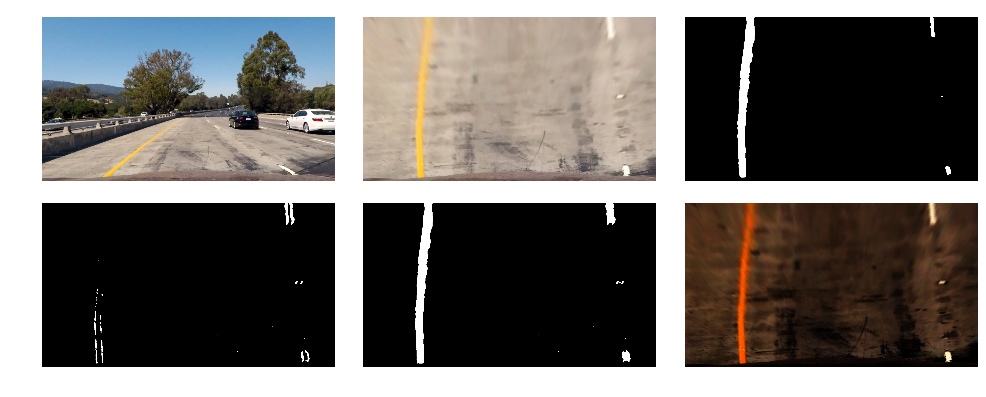

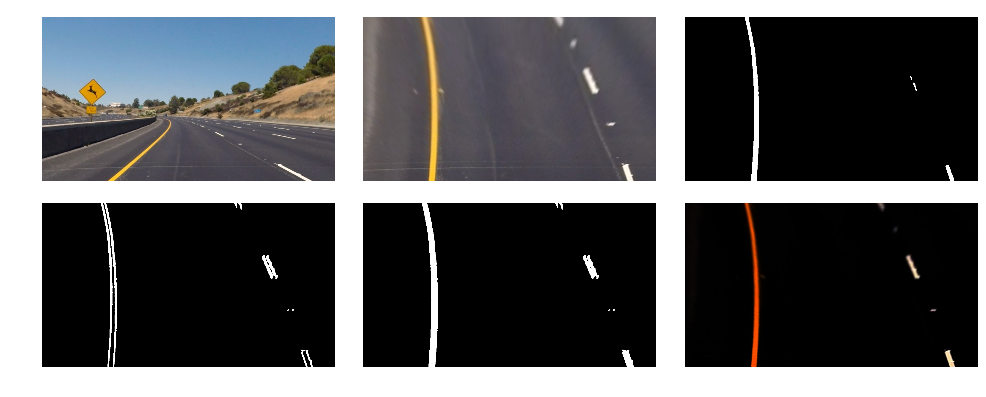

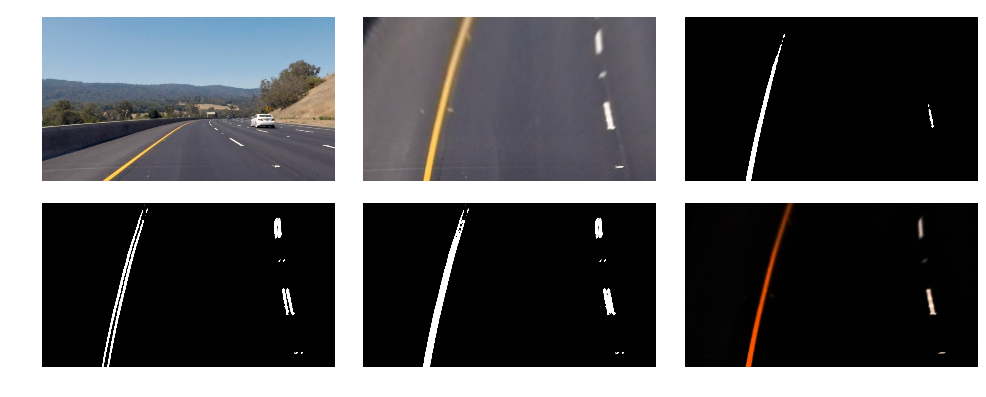

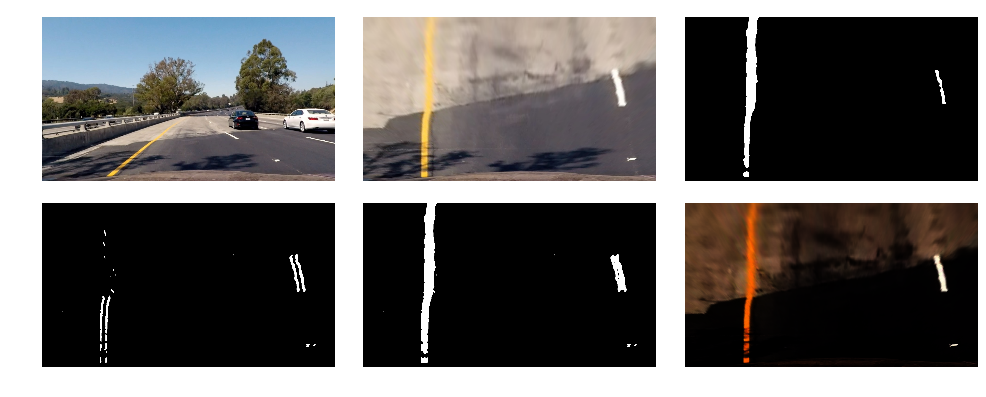

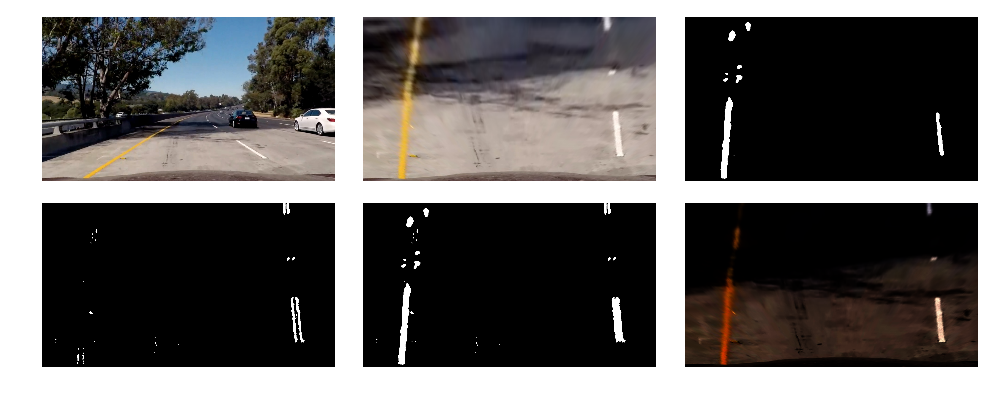

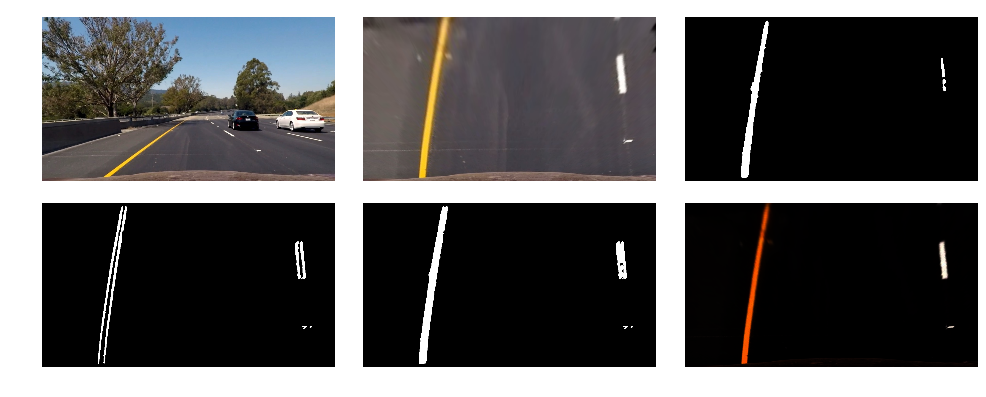

In [10]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.array([[490, 482],[810, 482],
                  [1250, 720],[40, 720]], dtype=np.float32)
    dst = np.array([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]], dtype=np.float32)
    
    bird_view_transformer = Perspective_Transform(src, dst)

    for path in glob.glob("./test_images/test*.jpg"):
        fig, axes = plt.subplots(2, 3, figsize=(10, 4))
        distorted_img = mpimg.imread(path)
        undist_img = get_undistortion(distorted_img, mtx, dist)
        bird_view = bird_view_transformer.transform(undist_img)            
        s_binary, slope, conversion_img = color_slope_thres_conversion(bird_view)
        
        gamma = adjust_gamma(bird_view, 0.2)
        
        axes[0, 0].imshow(undist_img)
        axes[0, 1].imshow(bird_view)
        axes[0, 2].imshow(s_binary, cmap='gray')
        axes[1, 0].imshow(slope, cmap='gray')
        axes[1, 1].imshow(conversion_img, cmap='gray')
        axes[1, 2].imshow(gamma, cmap='gray')
        fig.tight_layout()
        [ax.axis('off') for axe in axes for ax in axe]
        fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Histogram Filtering and Calculate curvature

In [11]:
def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

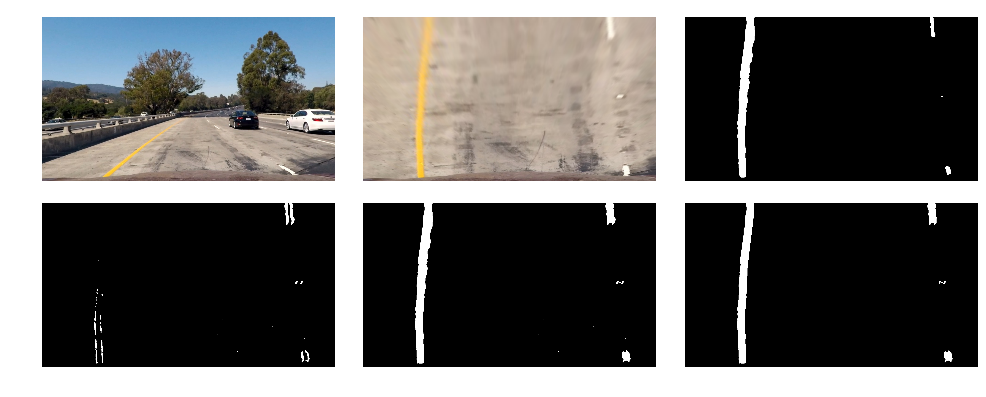

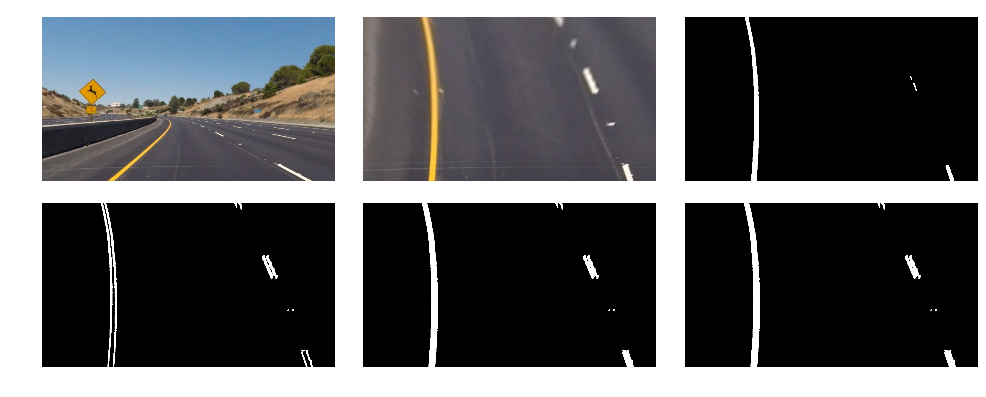

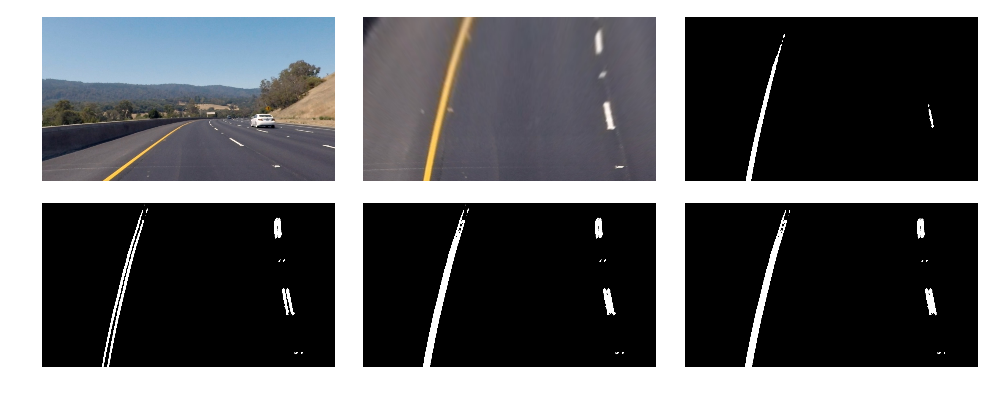

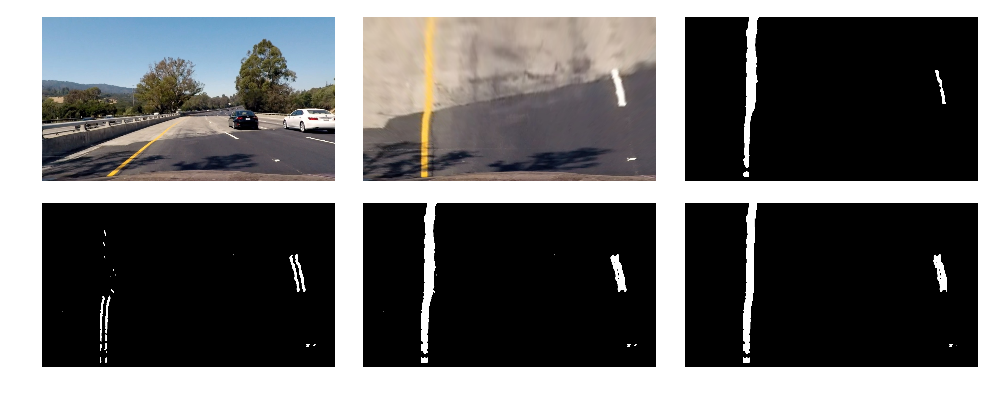

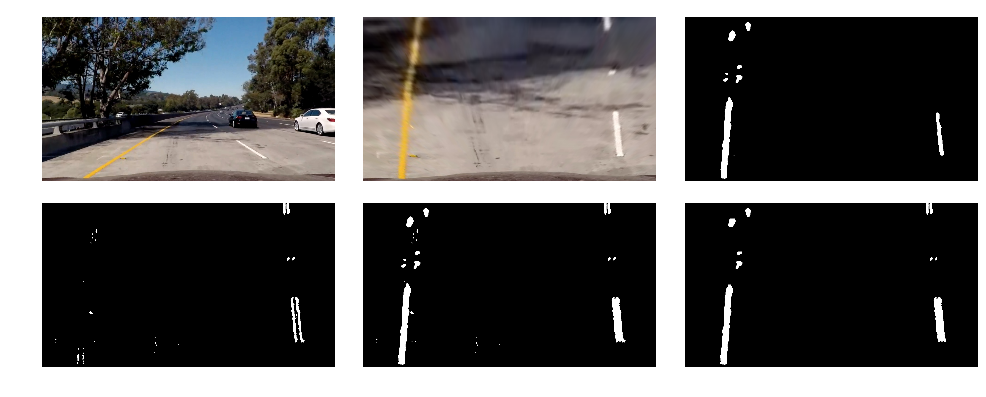

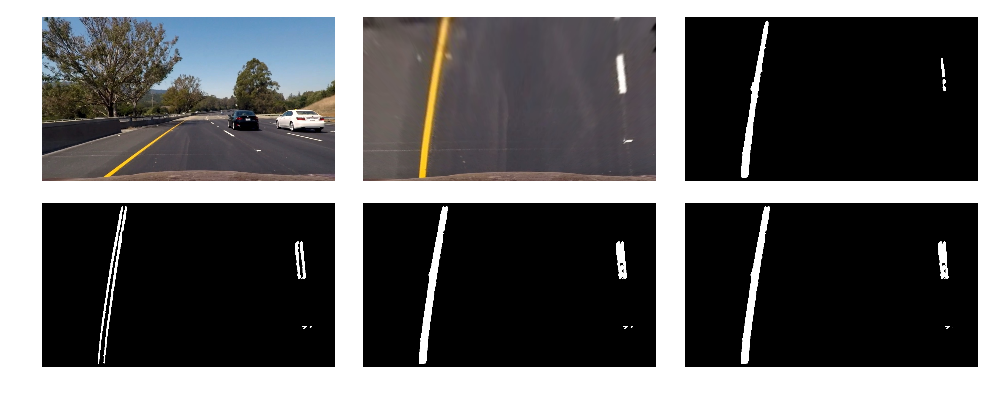

In [12]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.array([[490, 482],[810, 482],
                  [1250, 720],[40, 720]], dtype=np.float32)
    dst = np.array([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]], dtype=np.float32)
    
    bird_view_transformer = Perspective_Transform(src, dst)

    for path in glob.glob("./test_images/test*.jpg"):
        fig, axes = plt.subplots(2, 3, figsize=(10, 4))
        distorted_img = mpimg.imread(path)
        undist_img = get_undistortion(distorted_img, mtx, dist)
        bird_view = bird_view_transformer.transform(undist_img)            
        s_binary, slope, conversion_img = color_slope_thres_conversion(bird_view)
        
        a = conversion_img.copy()
        
        final_img, left_lines, right_lines, yvals = histogram(a, xsteps=20, ysteps=25, window_width=15)
        new_image = np.zeros_like(final_img)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        axes[0, 0].imshow(undist_img)
        axes[0, 1].imshow(bird_view)
        axes[0, 2].imshow(s_binary, cmap='gray')
        axes[1, 0].imshow(slope, cmap='gray')
        axes[1, 1].imshow(conversion_img, cmap='gray')
        axes[1, 2].imshow(final_img, cmap='gray')
        fig.tight_layout()
        [ax.axis('off') for axe in axes for ax in axe]
        fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Apply to movie

In [59]:
def process_image(img):
    try:
        calibration_param = input_calibration_file()
    except IOError as e:
        sys.exit()
    else:
        mtx = calibration_param['mtx']
        dist = calibration_param['dist']
        src = np.array([[490, 482],[810, 482],
                      [1250, 720],[40, 720]], dtype=np.float32)
        dst = np.array([[0, 0], [1280, 0], 
                         [1250, 720],[40, 720]], dtype=np.float32)

        bird_view_transformer = Perspective_Transform(src, dst)

        distorted_img = img
        undist_img = get_undistortion(distorted_img, mtx, dist)
        bird_view = bird_view_transformer.transform(undist_img)            
        s_binary, slope, conversion_img = color_slope_thres_conversion(bird_view)

        a = conversion_img.copy()
        final_img, left_lines, right_lines, yvals = histogram(a, xsteps=20, ysteps=25, window_width=15)
        new_image = np.zeros_like(final_img)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1

        new_image = bird_view_transformer.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color

        return undist_img

In [60]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)

    output = './output.mp4'
    clip1 = VideoFileClip('./mini.mp4')
    white_clip = clip1.fl_image(process_image)
    white_clip.write_videofile(output, audio=False)
    print("process Finished. Please view %s" % output)

finish get_calibration_param
[MoviePy] >>>> Building video ./output_mini3.mp4
[MoviePy] Writing video ./output_mini3.mp4


 99%|█████████▊| 74/75 [00:14<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_mini3.mp4 

process Finished. Please view ./output_mini3.mp4


In [13]:
import sys
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [14]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return mtx, dist

def get_undistortion(distorted_img, mtx, dist):
    undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    return undist

def input_calibration_file(path="./calibration.npz"):
    try:
        calibration_param = np.load(path)
        return calibration_param['mtx'], calibration_param['dist']
    except IOError as e:
        print(e)
        raise IOError("Please Set Correct Calibration File")

class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))
    
def get_s_binary(undist_img, thres=(110, 255)): #110
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1 #30
    s_binary = gaussian_blur(s_binary, kernel_size=21)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    #dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.3, 1.8))    
    #slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=9) # 5

    return slope_binary

def color_slope_thres_conversion(undist_img):
    s_binary = get_s_binary(undist_img, thres=(150, 255))
    slope = get_slope(undist_img, orient='x',sobel_kernel=7, thres=(25, 255)) #3, 30

    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (slope == 1)] = 1
    
    return color_binary

def histogram_thresholding(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line, left_line_equation = cal_poly(img, 0, boundary)
    right_fit_line, right_line_equation = cal_poly(img, boundary, img.shape[1])
           
    return img, left_fit_line, right_fit_line, left_line_equation, right_line_equation


def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    if xvals.size != 0:
        fit_equation = np.polyfit(yvals, xvals, 2)
        yvals = np.arange(img.shape[0])
        fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
        return fit_line, fit_equation
    else:
        return 0, np.array([10000., 100., 100.])
    
def mask_image_by_lines(image, left_lines, right_lines, yvals):
    new_image = np.zeros_like(image)
    for yv, ll in zip(yvals, left_lines):
        new_image[yv, ll-10:ll+10] = 1
    for yv, rl in zip(yvals, right_lines):
        new_image[yv, rl-10 : rl+10] = 1
    return new_image

def add_lines_to_image(undist_img, new_image):
    index = np.where(new_image == 1)
    pt = np.vstack((index[1], index[0]))
    pt = np.transpose(pt)
    cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
    undist_img[new_image==1] = [255, 0, 0]
    return undist_img

In [27]:
class Line(object):
    def __init__(self):
        self.detected = False
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None # average of x values of the fitted line over the last n iteration
        self.best_fit = None #average of polyminal coefficients over the last n iterations
        self.current_fit = [np.array([False])]
        self.current_x = None
        self.radius_of_curvature = None
        self.line_base_pos = None
        self.diffs = np.array([0, 0, 0], dtype="float")
        self.allx = None
        self.ally = None
    
class Line_detector(object):
    def __init__(self, calibration_path="./calibration.npz"):
        self.left_line = Line()
        self.right_line = Line()
        src = np.array([[490, 482],[810, 482],
                        [1250, 720],[40, 720]], dtype=np.float32)
        dst = np.array([[0, 0], [1280, 0], 
                        [1250, 720],[40, 720]], dtype=np.float32)
        self.bird_view_transformer =Perspective_Transform(src, dst)
        self.yvals = np.arange(720)
        self.detected = None
        self.count = 0
        
        try:
            self.camera_mtx, self.dist_coeff = input_calibration_file(path=calibration_path)
        except IOError as e:
            sys.exit()
    
    def get_filtered_img_and_cal_poly(self, converted_img, width=30):
        image = self.mask_image_by_average_lines(converted_img, width=width)
        _, self.left_line.current_fit = self.cal_poly(image, 0, int(image.shape[1] / 2))
        _, self.right_line.current_fit = self.cal_poly(image, int(image.shape[1] / 2), image.shape[1])
        return image

    def mask_image_by_average_lines(self, converted_img, width=30):
        image = np.zeros_like(converted_img)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            image[yv, ll-width:ll+width] = converted_img[yv, ll-width:ll+width]
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            image[yv, rl-width:rl+width] = converted_img[yv, rl-width:rl+width]
        return image
    
    def mask_image_by_lines(self, original_image, width=10):
        image = np.zeros_like(original_image)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            image[yv, ll-width:ll+width] = 1
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            image[yv, rl-width : rl+width] = 1
        return image
    
    def cal_poly(self, img, left_boundary, right_boundary):
        side_img = img[:, left_boundary: right_boundary].copy()
        index = np.where(side_img == 1)
        yvals = index[0]
        xvals = index[1] + left_boundary
        if xvals.size != 0:
            fit_equation = np.polyfit(yvals, xvals, 2)
            fit_line = fit_equation[0]*self.yvals**2 + fit_equation[1]*self.yvals + fit_equation[2]
            return fit_line, fit_equation
        else:
            return 0, np.array([10000., 100., 100.])
        
    def check_parallel(self):
        return True if (np.abs(self.left_line.current_fit[0] - self.right_line.current_fit[0]) < 0.01) else False
        
    def check_similarity(self, side='left'):
        if side == 'left':
            return True if (np.abs(self.left_line.current_fit[0] - self.left_line.best_fit[0]) < 0.0005) else False
        else:
            return True if (np.abs(self.right_line.current_fit[0] - self.right_line.best_fit[0]) < 0.0005) else False
            
    def check_line(self):
        return self.check_similarity(side='right') and self.check_similarity(side='left') and self.check_parallel()
    
    def cal_bestx_and_fit(self, weight=0.2):
        self.left_line.best_fit = self.left_line.best_fit * (1 - weight) + self.left_line.current_fit * weight
        self.left_line.bestx = self.left_line.best_fit[0]*self.yvals**2 + self.left_line.best_fit[1]*self.yvals + self.left_line.best_fit[2]
        self.right_line.best_fit = self.right_line.best_fit * (1 - weight) + self.right_line.current_fit * weight
        self.right_line.bestx = self.right_line.best_fit[0]*self.yvals**2 + self.right_line.best_fit[1]*self.yvals + self.right_line.best_fit[2]
        self.count = 0
        
    def add_curvature_to_image(self, image):
        self.__cal_curvature()
        curvature = int((self.left_line.radius_of_curvature+self.right_line.radius_of_curvature)/2)
        cv2.putText(
            image, 'Radius of Curvature {}(m)'.format(curvature), 
                    (120,140), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        return image
        
    def __cal_curvature(self):
        """Compute radius of curvature for each lane in meters"""
        ym_per_pix = 30./720 
        xm_per_pix = 3.7/700
        
        left_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.left_line.bestx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.right_line.bestx * xm_per_pix, 2)
        
        self.left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*np.max(self.yvals) + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        self.right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*np.max(self.yvals) + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
       
    def add_place_to_image(self, image):
        place = (self.left_line.bestx[-1] + self.right_line.bestx[-1]) / 2
        diff_center = np.abs((image.shape[1] / 2 - place) * 3.7 / 700)
        
        if place > image.shape[1] / 2:
            cv2.putText(image, 'Vehicle is {:.2f}m left of center'.format(diff_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        else:
            cv2.putText(image, 'Vehicle is {:.2f}m right of center'.format(diff_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        return image

    def process_image(self, distorted_image):
        undist_img = get_undistortion(distorted_image, self.camera_mtx, self.dist_coeff)
        bird_view = self.bird_view_transformer.transform(undist_img)            
        converted_img = color_slope_thres_conversion(bird_view)    
        if self.detected:
            final_bird_view_img = self.get_filtered_img_and_cal_poly(converted_img, width=50)
            if self.check_line():
                self.cal_bestx_and_fit()
            else:
                self.count += 1
                if self.count == 2:
                    self.detected = None
                    self.count = 0
        else:
            final_bird_view_img, left_line, right_line, left_line_equation, right_line_equation = histogram_thresholding(converted_img, xsteps=20, ysteps=25, window_width=15)
            self.left_line.current_fit = left_line_equation
            self.right_line.current_fit = right_line_equation
            
            if not self.check_parallel():
                self.detected = False
            else:
                self.left_line.bestx = left_line
                self.left_line.best_fit = left_line_equation
                self.right_line.bestx = right_line
                self.right_line.best_fit = right_line_equation
                self.detected = True
                        
        final_bird_view_img = self.mask_image_by_lines(final_bird_view_img)
        new_image = self.bird_view_transformer.inv_transform(final_bird_view_img)
        undist_img = add_lines_to_image(undist_img, new_image)
        undist_img = self.add_curvature_to_image(undist_img)
        undist_img = self.add_place_to_image(undist_img)
        return undist_img

In [28]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)
    output = './output3.mp4'
    clip1 = VideoFileClip('./project_video.mp4')
    ld = Line_detector()
    white_clip = clip1.fl_image(ld.process_image)
    white_clip.write_videofile(output, audio=False)
    print("process Finished. Please view %s" % output)

finish get_calibration_param
[MoviePy] >>>> Building video ./output3.mp4
[MoviePy] Writing video ./output3.mp4


100%|█████████▉| 1260/1261 [03:04<00:00,  7.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output3.mp4 

process Finished. Please view ./output3.mp4


In [83]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)
    output = './output_ch.mp4'
    clip1 = VideoFileClip('./challenge_video.mp4')
    ld = Line_detector()
    white_clip = clip1.fl_image(ld.process_image)
    white_clip.write_videofile(output, audio=False)
    print("process Finished. Please view %s" % output)

finish get_calibration_param
[MoviePy] >>>> Building video ./output_ch.mp4
[MoviePy] Writing video ./output_ch.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<00:56,  8.51it/s]

  0%|          | 2/485 [00:00<00:57,  8.44it/s]

  1%|          | 3/485 [00:00<00:56,  8.60it/s]

  1%|          | 4/485 [00:00<00:54,  8.75it/s]

  1%|          | 5/485 [00:00<00:54,  8.84it/s]

  1%|          | 6/485 [00:00<00:53,  8.94it/s]

  1%|▏         | 7/485 [00:00<00:53,  8.91it/s]

  2%|▏         | 8/485 [00:00<00:54,  8.81it/s]

  2%|▏         | 9/485 [00:01<00:55,  8.65it/s]

  2%|▏         | 10/485 [00:01<00:56,  8.46it/s]

  2%|▏         | 11/485 [00:01<00:56,  8.45it/s]

  2%|▏         | 12/485 [00:01<00:56,  8.41it/s]

  3%|▎         | 13/485 [00:01<00:55,  8.44it/s]

  3%|▎         | 14/485 [00:01<00:55,  8.45it/s]

  3%|▎         | 15/485 [00:01<00:54,  8.61it/s]

  3%|▎         | 16/485 [00:01<00:53,  8.75it/s]

  4%|▎         | 17/485 [00:01<00:52,  8.85it/s]

  4%|▎         | 18/485 [00:02<00:52,  8.95it/s]

  4%|▍         | 19/485 [00:02<00:52,  8.85it/s]

  4%|▍         |

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_ch.mp4 

process Finished. Please view ./output_ch.mp4


# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Calculate-the-correct-camera-matrix-and-distortion-coefficients" data-toc-modified-id="Calculate-the-correct-camera-matrix-and-distortion-coefficients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate the correct camera matrix and distortion coefficients</a></div><div class="lev2 toc-item"><a href="#Radial-Distortion" data-toc-modified-id="Radial-Distortion-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Radial Distortion</a></div><div class="lev2 toc-item"><a href="#Tangential-Distortion" data-toc-modified-id="Tangential-Distortion-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tangential Distortion</a></div><div class="lev2 toc-item"><a href="#To-undistortion" data-toc-modified-id="To-undistortion-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>To undistortion</a></div><div class="lev1 toc-item"><a href="#Calculate-the-correct-camera-matrix-and-distortion-coefficients" data-toc-modified-id="Calculate-the-correct-camera-matrix-and-distortion-coefficients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate the correct camera matrix and distortion coefficients</a></div><div class="lev2 toc-item"><a href="#Radial-Distortion" data-toc-modified-id="Radial-Distortion-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Radial Distortion</a></div><div class="lev2 toc-item"><a href="#Tangential-Distortion" data-toc-modified-id="Tangential-Distortion-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tangential Distortion</a></div><div class="lev2 toc-item"><a href="#To-undistortion" data-toc-modified-id="To-undistortion-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>To undistortion</a></div><div class="lev2 toc-item"><a href="#Visualize-Undistorted-Test-Image" data-toc-modified-id="Visualize-Undistorted-Test-Image-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize Undistorted Test Image</a></div><div class="lev2 toc-item"><a href="#Perspective-Transform" data-toc-modified-id="Perspective-Transform-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Perspective Transform</a></div><div class="lev2 toc-item"><a href="#Color-Thresholding,-Binary-Thresholding" data-toc-modified-id="Color-Thresholding,-Binary-Thresholding-26"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Color Thresholding, Binary Thresholding</a></div><div class="lev2 toc-item"><a href="#Histogram-Filtering-and-Calculate-curvature" data-toc-modified-id="Histogram-Filtering-and-Calculate-curvature-27"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Histogram Filtering and Calculate curvature</a></div><div class="lev2 toc-item"><a href="#Apply-to-movie" data-toc-modified-id="Apply-to-movie-28"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Apply to movie</a></div>